In [11]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation
import matplotlib.patches as mpatches
from lightning_threshold_functions import *

In [12]:
rainband_shear_timebin_joined = pd.read_csv("../data_pipeline/data/rainband_shear_timebin_joined.csv")
rainband_shear_timebin_joined = pl.from_pandas(rainband_shear_timebin_joined)

In [13]:
rainband_shear_timebin_joined.head()

time_bin,shear_quad,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,24_hour_knots_diff,24_hour_pressure_diff,TC_Category,Intensification_Category
str,str,str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,f64,f64,str,str
"""2010-06-25 15:00:00""","""DL""","""ATL_10_1""",75,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""Unidentified""","""Intensifying"""
"""2010-06-25 15:00:00""","""DR""","""ATL_10_1""",11,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""Unidentified""","""Intensifying"""
"""2010-06-25 15:00:00""","""UL""","""ATL_10_1""",0,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""Unidentified""","""Intensifying"""
"""2010-06-25 15:00:00""","""UR""","""ATL_10_1""",26,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""Unidentified""","""Intensifying"""
"""2010-06-25 15:30:00""","""DL""","""ATL_10_1""",2,2010,6,25,15,30,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""Unidentified""","""Intensifying"""


In [14]:
# import data from csv file
rainband_shear_timebin_joined = rainband_shear_timebin_joined.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
rainband_shear_timebin_joined = rainband_shear_timebin_joined.with_columns(
    pl.when(pl.col("TC_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("TC_Category"))
    .alias("TC_Category")
)
rainband_shear_timebin_joined = rainband_shear_timebin_joined.rename({"Intensification_Category":"Intensification_Category_5", "TC_Category":"Current_Category"})
rainband_shear_timebin_joined.head()


time_bin,shear_quad,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category_5,log_lightning_count
datetime[μs],str,str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,f64,f64,str,str,f64
2010-06-25 15:00:00,"""DL""","""ATL_10_1""",75,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",4.330733
2010-06-25 15:00:00,"""DR""","""ATL_10_1""",11,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",2.484907
2010-06-25 15:00:00,"""UL""","""ATL_10_1""",0,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",0.0
2010-06-25 15:00:00,"""UR""","""ATL_10_1""",26,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",3.295837
2010-06-25 15:30:00,"""DL""","""ATL_10_1""",2,2010,6,25,15,30,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",1.098612


In [15]:
# Mapping intensification bins into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
rainband_shear_timebin_joined = rainband_shear_timebin_joined.with_columns(
    rainband_shear_timebin_joined["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

rainband_shear_timebin_joined.head()

time_bin,shear_quad,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category_5,log_lightning_count,Intensification_Category_3
datetime[μs],str,str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,f64,f64,str,str,f64,str
2010-06-25 15:00:00,"""DL""","""ATL_10_1""",75,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",4.330733,"""Intensifying"""
2010-06-25 15:00:00,"""DR""","""ATL_10_1""",11,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",2.484907,"""Intensifying"""
2010-06-25 15:00:00,"""UL""","""ATL_10_1""",0,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",0.0,"""Intensifying"""
2010-06-25 15:00:00,"""UR""","""ATL_10_1""",26,2010,6,25,15,0,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",3.295837,"""Intensifying"""
2010-06-25 15:30:00,"""DL""","""ATL_10_1""",2,2010,6,25,15,30,16.4,-83.0,1005,30,"""Alex""",2,"""ATL""",25.0,-7.0,"""0""","""Intensifying""",1.098612,"""Intensifying"""


In [16]:
storm_names = rainband_shear_timebin_joined[["storm_code", "storm_name"]].unique()

In [17]:
# Filter out data where wind is less than 40 knots for threshold analysis
analysis_data = rainband_shear_timebin_joined.filter(pl.col("knots") >= 40)
# Convert polars dataframe to pandas for application of functions
pd_data = analysis_data.to_pandas()

# Apply functions to data, including bins with 0 lightning
bursts_w_0 = apply_individual_thresholds_quad(pd_data)

tc_summary_w_0 = create_tc_summary_quad(bursts_w_0)
tc_summary_w_0.head(30)

#Get mean threshold value for each of the 6 options
# tc_summary_w_0_mean = tc_summary_w_0.drop(columns=(["storm_code",'shear_quad'])).mean()
# print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# # Get median threshold value for each of the 6 options
# tc_summary_w_0_median = tc_summary_w_0.drop(columns=(["storm_code",'shear_quad'])).median()
# print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

# # Get mean threshold value for each of the 6 options
# tc_summary_w_0_mean = tc_summary_w_0.drop(columns=(["storm_code",'shear_quad'])).mean()
# print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# # Get median threshold value for each of the 6 options
# tc_summary_w_0_median = tc_summary_w_0.drop(columns=(["storm_code",'shear_quad'])).median()
# print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

,storm_code,shear_quad,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_1,DL,0,0,10.397208,12.476649,0,0,7.710822,9.638527,...,0,6.050360,7.960931,168,0.00,0.00,0.00,0.00,0.00,0.00
1,ATL_10_1,DR,26,10,3.465736,4.158883,1,0,5.478682,6.848352,...,0,4.572948,6.164564,168,15.48,5.95,0.60,0.00,2.98,0.00
2,ATL_10_1,UL,0,0,6.931472,8.317766,0,0,6.270988,7.838736,...,0,4.885247,6.530992,168,0.00,0.00,0.00,0.00,1.79,0.00
3,ATL_10_1,UR,77,77,0.000000,0.000000,13,5,3.660594,4.575743,...,3,4.021982,5.511745,168,45.83,45.83,7.74,2.98,4.76,1.79
4,ATL_10_11,DL,144,144,0.000000,0.000000,74,64,1.386294,1.732868,...,12,2.345035,3.274425,516,27.91,27.91,14.34,12.40,6.20,2.33
5,ATL_10_11,DR,86,41,3.465736,4.158883,0,0,5.666427,7.083033,...,0,4.667614,6.276847,516,16.67,7.95,0.00,0.00,3.10,0.00
6,ATL_10_11,UL,96,96,0.000000,0.000000,96,96,0.000000,0.000000,...,17,1.719073,2.430756,516,18.60,18.60,18.60,18.60,6.98,3.29
7,ATL_10_11,UR,250,250,0.000000,0.000000,12,1,3.891820,4.864775,...,1,3.577867,4.860058,516,48.45,48.45,2.33,0.19,5.23,0.19
8,ATL_10_12,DL,73,73,0.000000,0.000000,73,73,0.000000,0.000000,...,8,1.385080,1.951305,358,20.39,20.39,20.39,20.39,8.66,2.23
9,ATL_10_12,DR,127,127,0.000000,0.000000,54,47,1.386294,1.732868,...,8,2.523022,3.495847,358,35.47,35.47,15.08,13.13,6.98,2.23


<Figure size 1000x500 with 0 Axes>

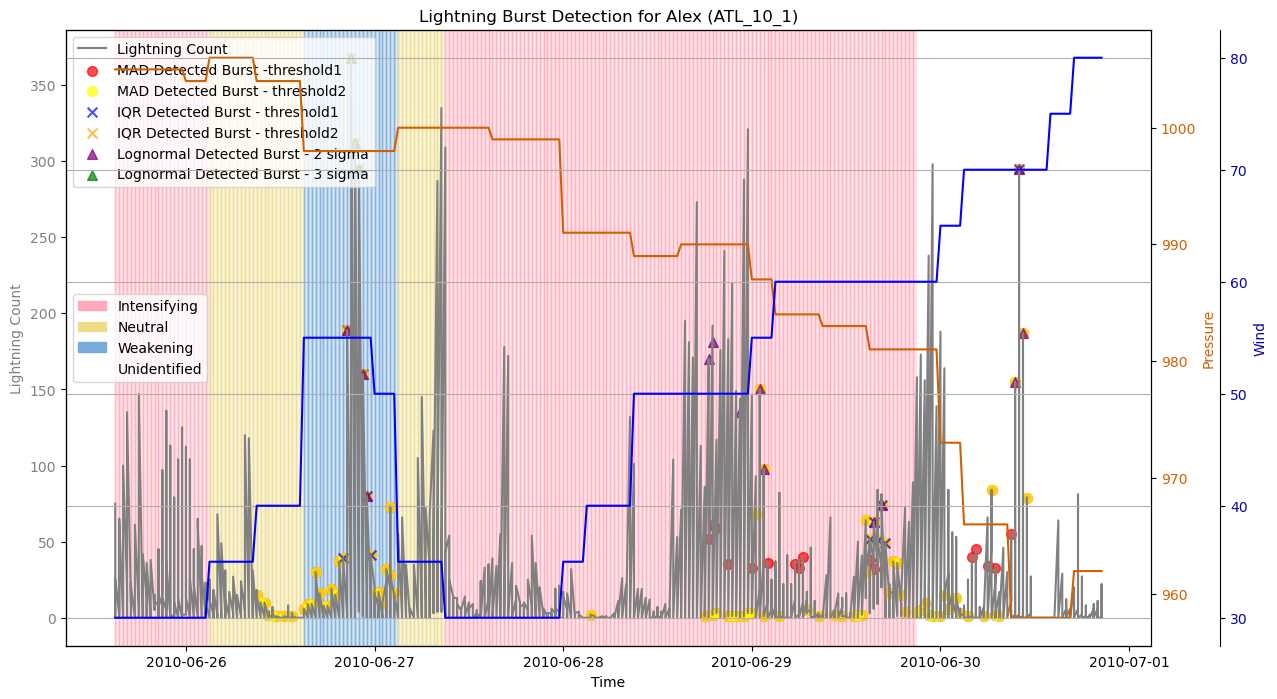

<Figure size 1000x500 with 0 Axes>

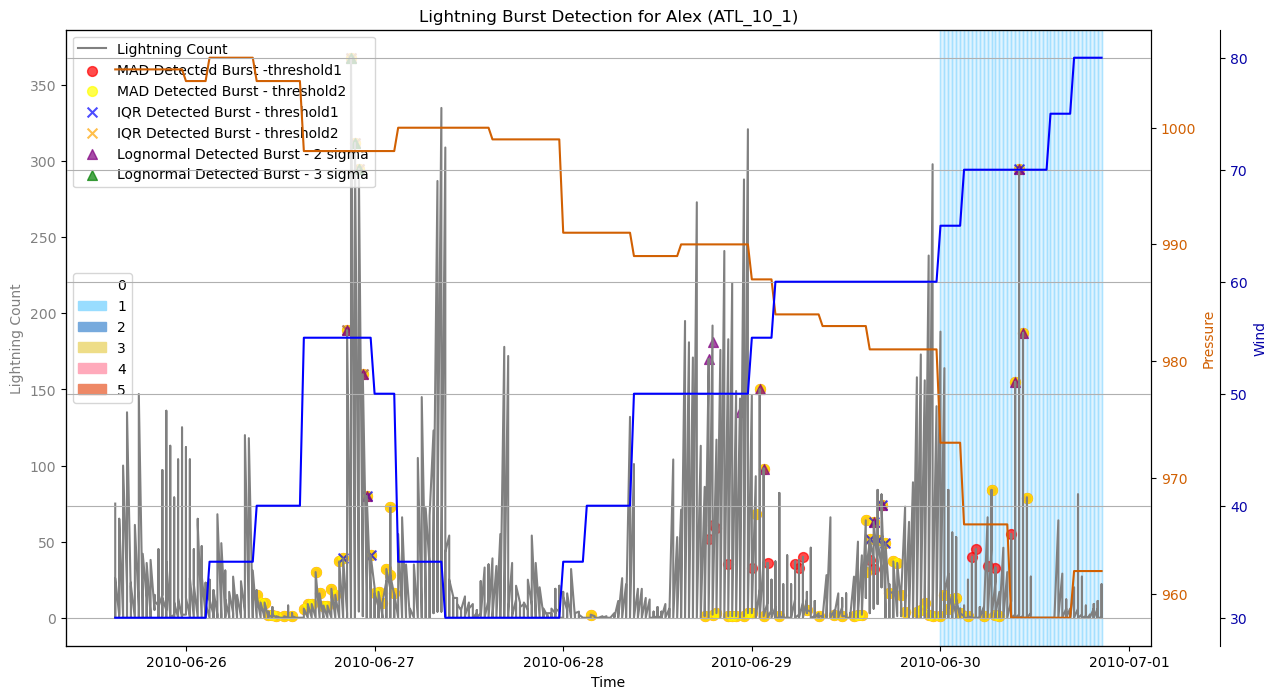

,storm_code,shear_quad,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_1,DL,0,0,10.397208,12.476649,0,0,7.710822,9.638527,...,0,6.050360,7.960931,168,0.00,0.00,0.00,0.00,0.00,0.00
1,ATL_10_1,DR,26,10,3.465736,4.158883,1,0,5.478682,6.848352,...,0,4.572948,6.164564,168,15.48,5.95,0.60,0.00,2.98,0.00
2,ATL_10_1,UL,0,0,6.931472,8.317766,0,0,6.270988,7.838736,...,0,4.885247,6.530992,168,0.00,0.00,0.00,0.00,1.79,0.00
3,ATL_10_1,UR,77,77,0.000000,0.000000,13,5,3.660594,4.575743,...,3,4.021982,5.511745,168,45.83,45.83,7.74,2.98,4.76,1.79


In [18]:
# ATL_10_1 with 0 in the analysis
cyclone_id = 'ATL_10_1'
plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary_w_0[tc_summary_w_0["storm_code"] == cyclone_id]

In [19]:
# Apply functions to data(exclude 0 lightning count)
pd_data_drop0 = pd_data[pd_data['lightning_count'] != 0]

bursts = apply_individual_thresholds_quad(pd_data_drop0)

tc_summary = create_tc_summary_quad(bursts)
tc_summary = pd.merge(storm_names.to_pandas(), tc_summary, on="storm_code")
tc_summary.head(10)

,storm_code,storm_name,shear_quad,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,SHEM_10_23,Robyn,DL,6,6,0.693147,0.693147,1,1,2.079442,...,0,2.197457,2.753934,13,46.15,46.15,7.69,7.69,7.69,0.0
1,SHEM_10_23,Robyn,DR,0,0,2.407946,2.663358,0,0,2.525729,...,0,2.167099,2.624505,12,0.00,0.00,0.00,0.00,0.00,0.0
2,SHEM_10_23,Robyn,UL,0,0,1.098612,1.098612,0,0,1.098612,...,0,NaN,NaN,1,0.00,0.00,0.00,0.00,0.00,0.0
3,WPAC_12_12,Haikui,DL,0,0,5.335102,6.182399,0,0,4.179502,...,0,3.719373,4.621607,82,0.00,0.00,0.00,0.00,1.22,0.0
4,WPAC_12_12,Haikui,DR,5,1,2.720473,3.125938,0,0,3.701302,...,0,3.003954,3.760806,59,8.47,1.69,0.00,0.00,1.69,0.0
5,WPAC_12_12,Haikui,UL,5,1,4.158883,4.852030,5,1,3.845143,...,0,4.191951,5.406505,44,11.36,2.27,11.36,2.27,9.09,0.0
6,WPAC_12_12,Haikui,UR,0,0,4.158883,4.852030,0,0,3.449988,...,0,3.177440,3.976128,27,0.00,0.00,0.00,0.00,3.70,0.0
7,WPAC_12_16,Bolaven,DL,0,0,4.158883,4.852030,1,0,2.890372,...,0,2.738096,3.438585,37,0.00,0.00,2.70,0.00,2.70,0.0
8,WPAC_12_16,Bolaven,DR,0,0,4.158883,4.852030,0,0,4.276666,...,0,3.695581,4.691587,89,0.00,0.00,0.00,0.00,3.37,0.0
9,WPAC_12_16,Bolaven,UL,0,0,0.693147,0.693147,0,0,0.693147,...,0,0.693147,0.693147,2,0.00,0.00,0.00,0.00,0.00,0.0


<Figure size 1000x500 with 0 Axes>

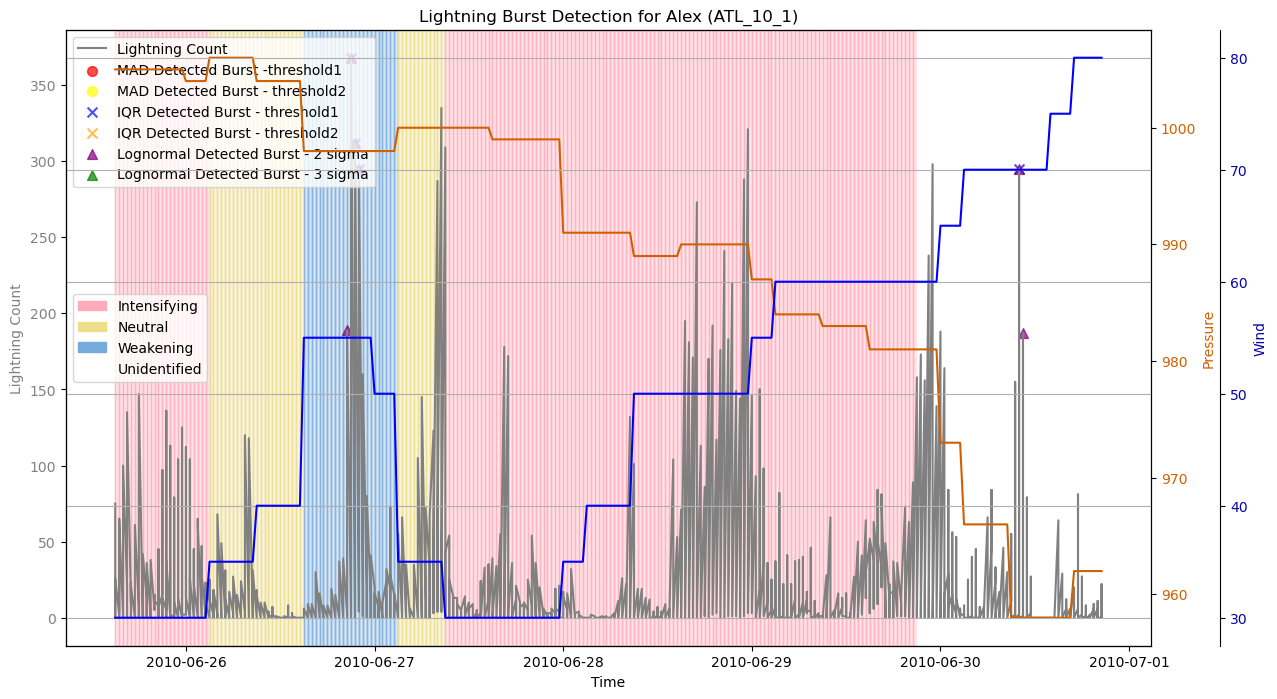

<Figure size 1000x500 with 0 Axes>

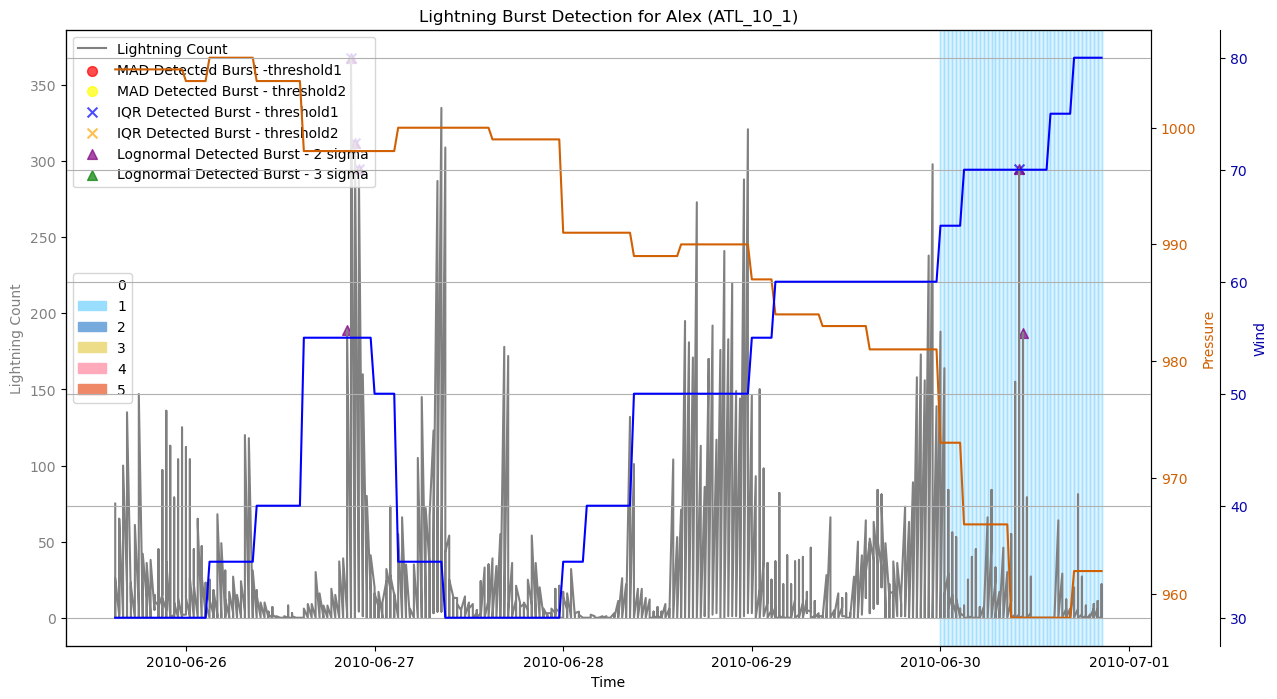

,storm_code,storm_name,shear_quad,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
733,ATL_10_1,Alex,DL,0,0,7.811623,9.015596,0,0,6.985906,...,0,6.179006,7.720952,121,0.0,0.0,0.00,0.0,0.00,0.0
734,ATL_10_1,Alex,DR,0,0,6.694026,7.726295,1,0,5.666427,...,0,5.148112,6.453297,92,0.0,0.0,1.09,0.0,2.17,0.0
735,ATL_10_1,Alex,UL,0,0,7.102499,8.201112,0,0,5.934894,...,0,5.218983,6.476196,99,0.0,0.0,0.00,0.0,0.00,0.0
736,ATL_10_1,Alex,UR,0,0,6.591674,7.690286,3,0,5.635979,...,0,5.129513,6.557045,77,0.0,0.0,3.90,0.0,5.19,0.0


In [20]:
# ATL_10_1 without 0 in threshold calculation
cyclone_id = 'ATL_10_1'
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

In [21]:
rainband_shear_timebin_joined_pd = rainband_shear_timebin_joined.to_pandas()
filtered_df = rainband_shear_timebin_joined_pd[rainband_shear_timebin_joined_pd['storm_code'].str.contains('^EPAC')]
filtered_df

,time_bin,shear_quad,storm_code,lightning_count,year,month,day,hour,minute,lat,...,knots,storm_name,category,basin,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category_5,log_lightning_count,Intensification_Category_3
78400,2010-06-18 15:00:00,DL,EPAC_10_4,0,2010,6,18,15,0,13.2,...,25,Celia,5,EPAC,15.0,-8.0,0,Intensifying,0.000000,Intensifying
78401,2010-06-18 15:00:00,DR,EPAC_10_4,0,2010,6,18,15,0,13.2,...,25,Celia,5,EPAC,15.0,-8.0,0,Intensifying,0.000000,Intensifying
78402,2010-06-18 15:00:00,UL,EPAC_10_4,3,2010,6,18,15,0,13.2,...,25,Celia,5,EPAC,15.0,-8.0,0,Intensifying,1.386294,Intensifying
78403,2010-06-18 15:00:00,UR,EPAC_10_4,0,2010,6,18,15,0,13.2,...,25,Celia,5,EPAC,15.0,-8.0,0,Intensifying,0.000000,Intensifying
78404,2010-06-18 15:30:00,DL,EPAC_10_4,0,2010,6,18,15,30,13.2,...,25,Celia,5,EPAC,15.0,-8.0,0,Intensifying,0.000000,Intensifying
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139647,2017-07-29 01:00:00,UR,EPAC_17_9,0,2017,7,29,1,0,20.0,...,55,Hilary,2,EPAC,NaN,NaN,0,Unidentified,0.000000,Unidentified
139648,2017-07-29 01:30:00,DL,EPAC_17_9,0,2017,7,29,1,30,20.0,...,55,Hilary,2,EPAC,NaN,NaN,0,Unidentified,0.000000,Unidentified
139649,2017-07-29 01:30:00,DR,EPAC_17_9,0,2017,7,29,1,30,20.0,...,55,Hilary,2,EPAC,NaN,NaN,0,Unidentified,0.000000,Unidentified
139650,2017-07-29 01:30:00,UL,EPAC_17_9,1,2017,7,29,1,30,20.0,...,55,Hilary,2,EPAC,NaN,NaN,0,Unidentified,0.693147,Unidentified


<Figure size 1000x500 with 0 Axes>

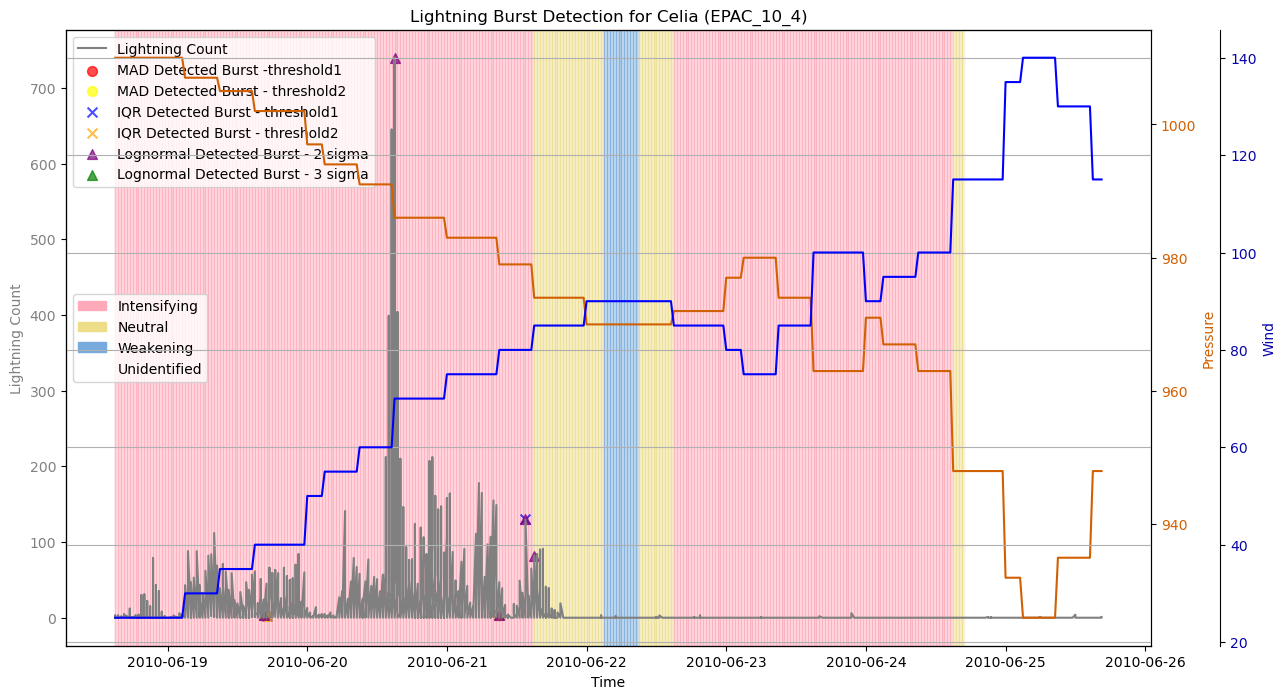

<Figure size 1000x500 with 0 Axes>

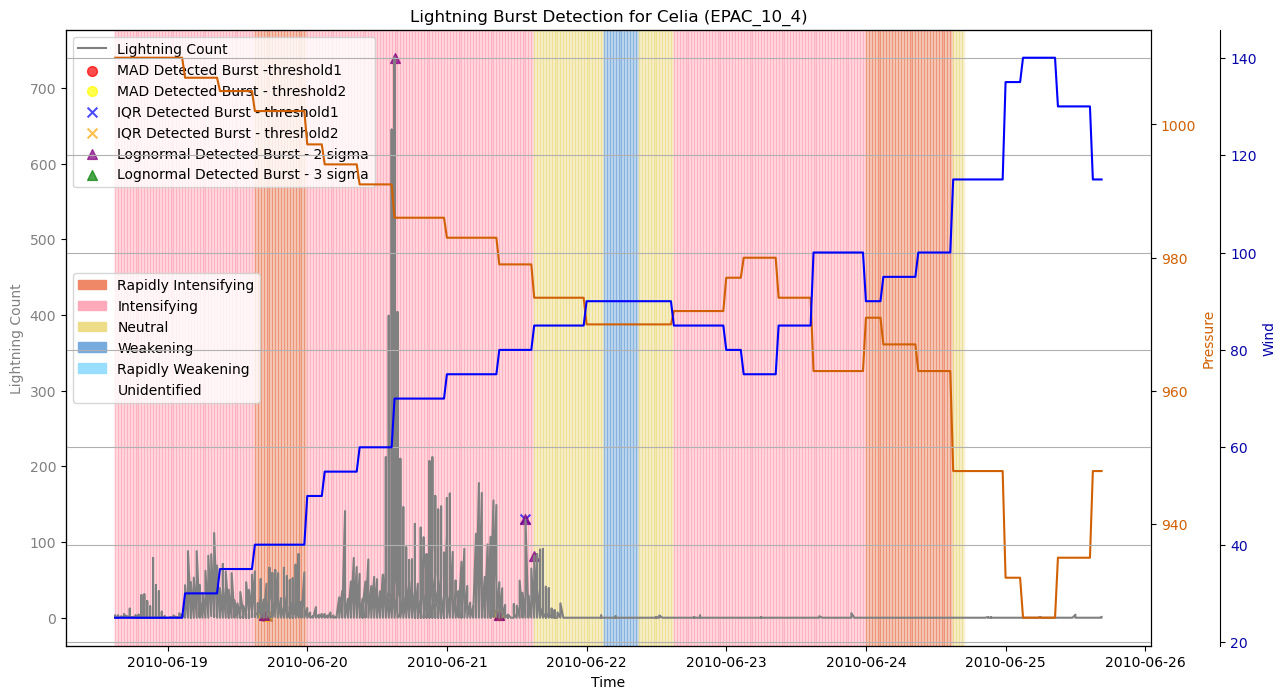

<Figure size 1000x500 with 0 Axes>

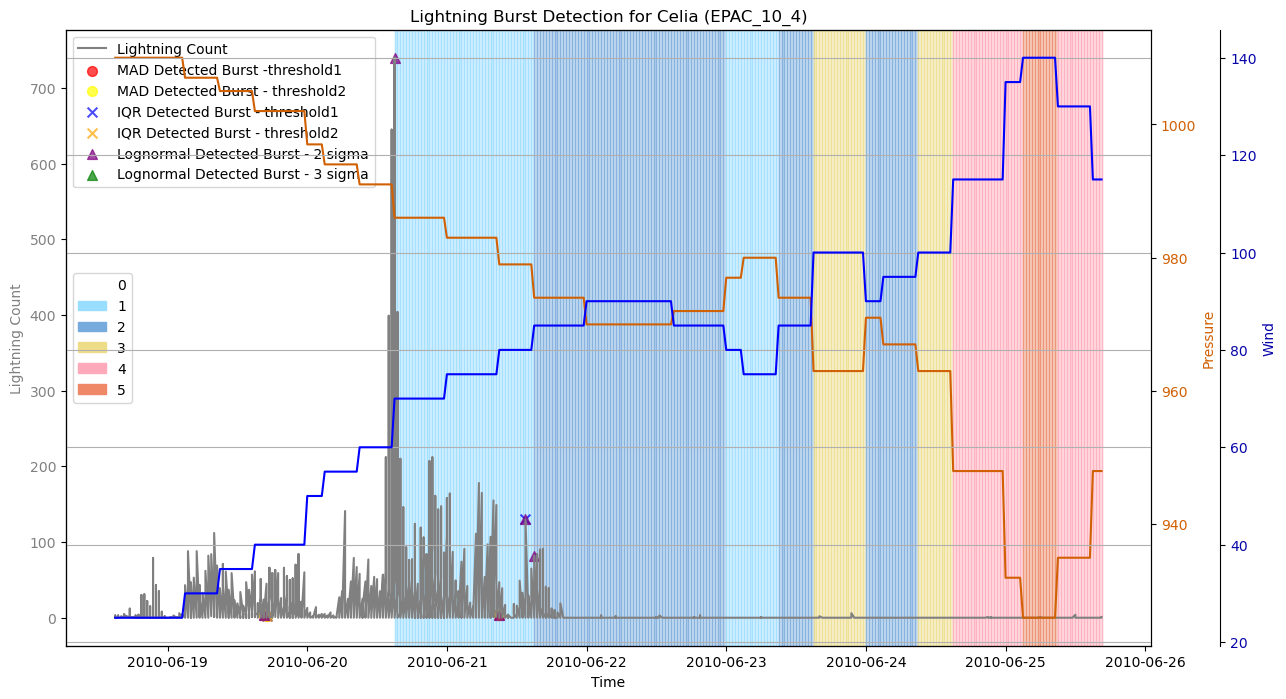

,storm_code,storm_name,shear_quad,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
202,EPAC_10_4,Celia,DL,0,0,5.941714,6.549284,0,0,5.490376,...,0,5.549242,6.685128,92,0.00,0.00,0.00,0.00,0.00,0.0
203,EPAC_10_4,Celia,DR,0,0,8.637703,9.856896,0,0,7.208113,...,0,6.597789,8.244136,80,0.00,0.00,0.00,0.00,1.25,0.0
204,EPAC_10_4,Celia,UL,3,3,0.693147,0.693147,3,3,0.693147,...,0,1.301696,1.549978,16,18.75,18.75,18.75,18.75,12.50,0.0
205,EPAC_10_4,Celia,UR,0,0,5.335102,6.182399,1,0,4.567814,...,0,4.408879,5.571854,41,0.00,0.00,2.44,0.00,4.88,0.0


In [22]:
# EPAC_18_16 - Norman
cyclone_id = 'EPAC_10_4'
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

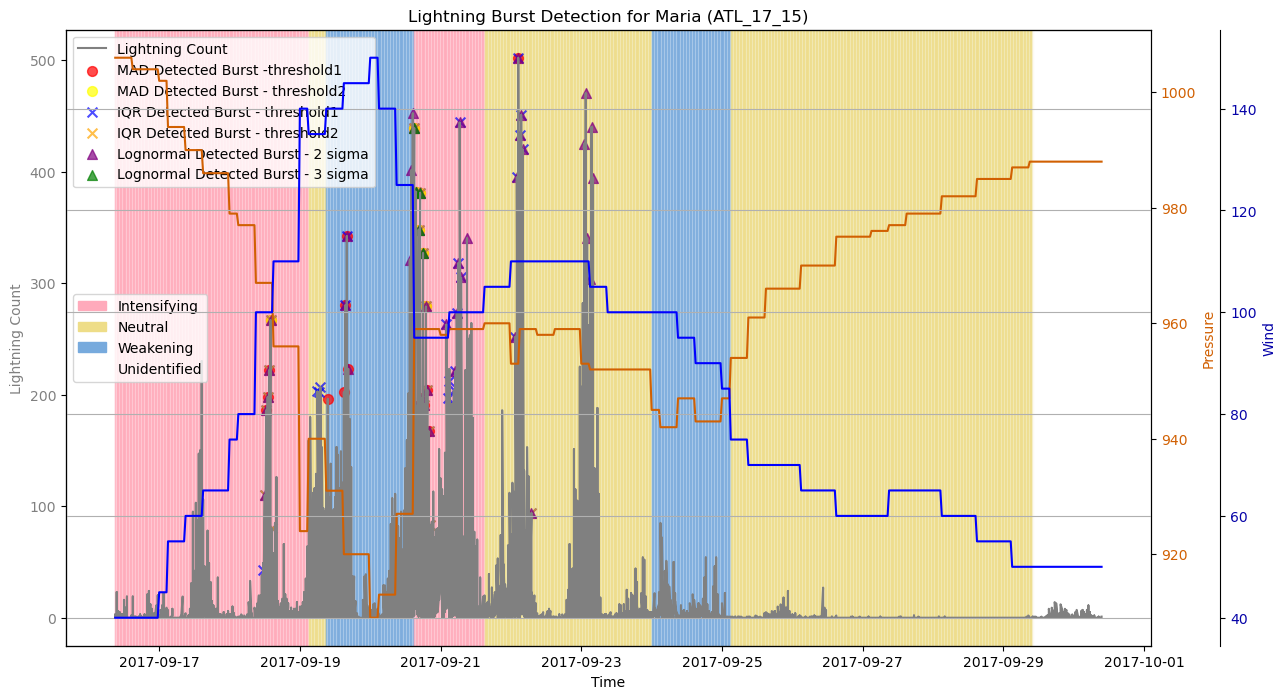

<Figure size 1000x500 with 0 Axes>

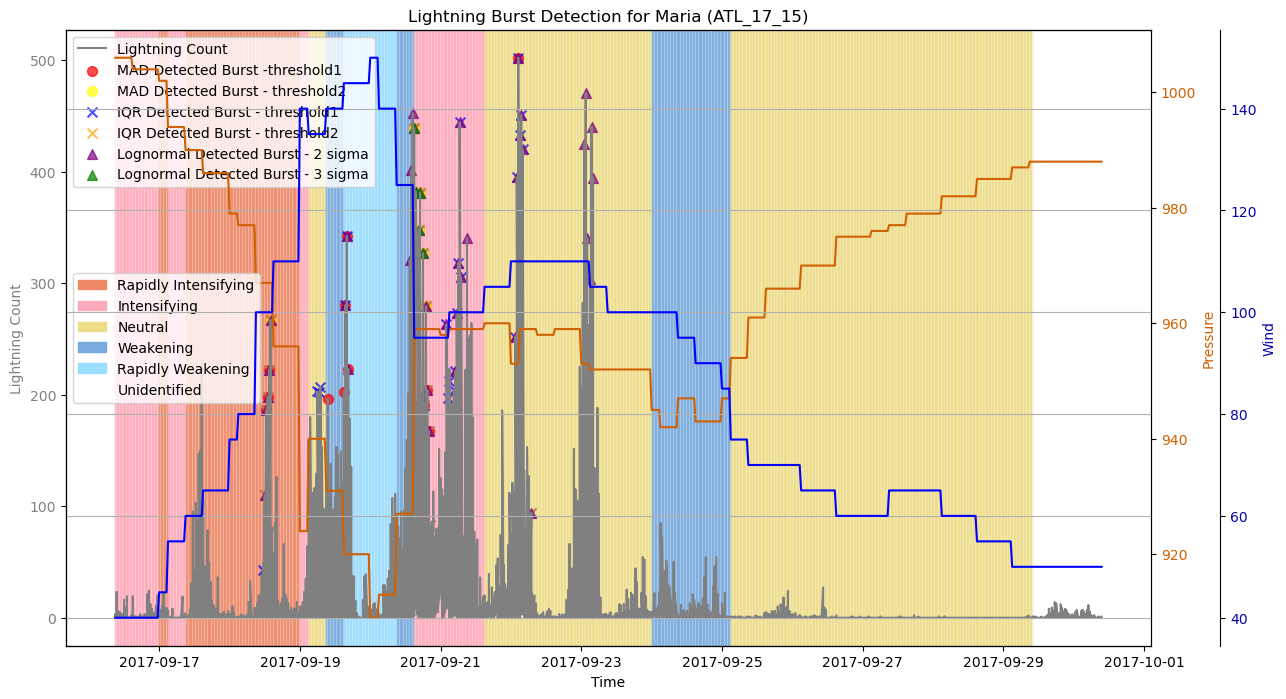

<Figure size 1000x500 with 0 Axes>

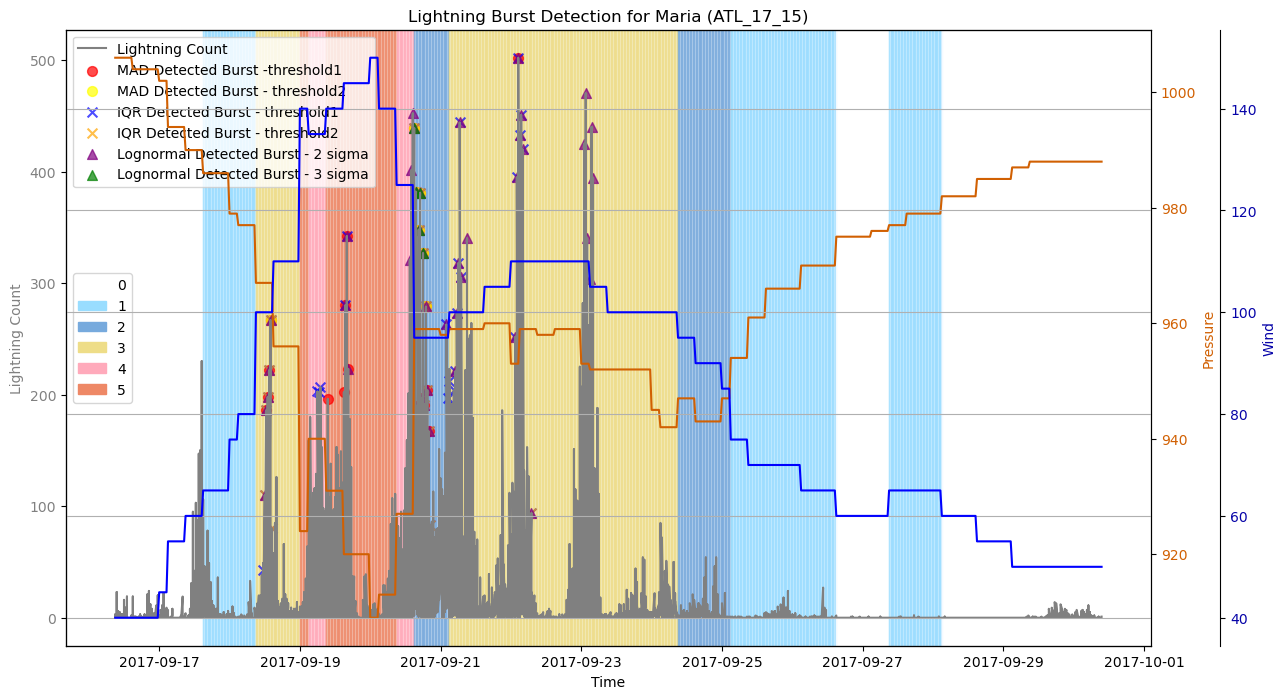

,storm_code,storm_name,shear_quad,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
1037,ATL_17_15,Maria,DL,15,7,4.763267,5.551725,23,19,3.697178,...,5,4.435825,5.701969,259,5.79,2.7,8.88,7.34,6.56,1.93
1038,ATL_17_15,Maria,DR,0,0,7.118476,8.322449,0,0,6.385921,...,0,5.675594,7.213287,352,0.00,0.0,0.00,0.00,2.84,0.00
1039,ATL_17_15,Maria,UL,5,0,5.274601,6.190892,2,0,5.565797,...,0,5.315818,6.866573,161,3.11,0.0,1.24,0.00,1.86,0.00
1040,ATL_17_15,Maria,UR,1,0,6.186209,7.284821,19,0,5.257495,...,0,5.361425,6.893356,273,0.37,0.0,6.96,0.00,4.40,0.00


In [23]:
# ATL_17_15 - Maria
cyclone_id = 'ATL_17_15'
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

In [15]:
# Export for external tool vis
# marker - rename files?

print('export originally here')
# innercore_data.write_csv("vis_data/tc_lightning_vis_data.csv")
# tc_summary.to_csv("vis_data/threshold_summary.csv")
# bursts.to_csv("vis_data/tc_threshold.csv")

export originally here


In [16]:
# Define threshold names for use later
threshold_names = {
    'mad1':['mad1_threshold','MAD1'],
    'mad2':['mad2_threshold','MAD2'],
    'iqr1':['iqr1_threshold','IQR1'],
    'iqr2':['iqr2_threshold','IQR2'],
    'logn1':['logn1_threshold','Lognormal 2 Sigma'],
    'logn2':['logn2_threshold','Lognormal 3 Sigma'],
}
threshold_keys = list(threshold_names.keys())
threshold_cols = [threshold_names[key][0] for key in threshold_keys]
threshold_labels = [threshold_names[key][1] for key in threshold_keys]

In [17]:
# No bursts detected
# marker - need to look into why the agg result dataframes are not the same length??
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
print(f"{(tc_summary_w_0[selected_columns].sum(axis=1) == 0).sum()} TCs of {len(tc_summary_w_0)} TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.")
no_bursts = tc_summary[tc_summary[selected_columns].sum(axis=1) == 0]
print(f"{len(no_bursts)} TCs of {len(tc_summary)} TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.")

75 TCs of 1212 TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.
22 TCs of 303 TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.
